Word2Vec & Linear SVC & description, title & 0.65 & 0.44  
Word2Vec & Gradient Boosting & description, title & 0.65 & 0.43  

In [1]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import KeyedVectors
import pandas as pd
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel 
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
import optuna
from optuna.pruners import SuccessiveHalvingPruner, HyperbandPruner

In [2]:
import numpy as np
np.random.seed(42)  # Set random seed for numpy

import random
random.seed(42)  # Set random seed for random module

In [3]:
df = pd.read_csv("D:\\MS DATA SCIENCE\\NLP TESE\\data\\data_processed_selected.csv")
df.head()

,date,title,reason,description,zone,narrative_tfidf,narrative_embeddings,narrative_bert,narrative_tfidf_title,narrative_bert_title,...,embeddings_title,tfidf_keywords,embeddings_keywords,events_clean,results_final,events_tfidf,events_embeddings,orgs,locs,entities
0,2021-10-11 12:26:32,CTT - Encomenda entregue danificada e com etiq...,0,Bom dia venho por este meio apresentar uma rec...,Lisboa,bom dia venho meio apresentar reclamação ctt e...,bom dia venho por este meio apresentar uma rec...,Bom dia venho por este meio apresentar uma rec...,ctt encomenda entregar danificar etiqueta envi...,ctt - encomenda entregue danificada e com etiq...,...,ctt - encomenda entregue danificada e com etiq...,apresentar reclamação caixa figura envio israe...,apresentar uma reclamação tinha caixa figura e...,venho apresentar enviei destinado feito proteg...,"[('CTT', 'B-ORGANIZACAO'), ('Israel', 'B-LOCAL...",venho apresentar enviar destinar fazer protege...,venho apresentar enviei destinado feito proteg...,"CTT, Aboboda",Israel,"CTT, Aboboda, Israel"
1,2021-08-31 23:20:15,CTT - Carta com certificado rasgado!,1,- Boa Noite!\r\n\r\n- Venho por este meio recl...,Coimbra,bom noite venho meio reclamar data ás durante ...,- boa noite!\r\n\r\n- venho por este meio recl...,- Boa Noite! Venho por este meio reclamar que ...,ctt carta certificar rasgar bom noite venho me...,ctt - carta com certificado rasgado! - Boa No...,...,ctt - carta com certificado rasgado !,lilia pimentel certificar profissional passage...,lilia pimentel certificado profissional passag...,venho reclamar deparei -me continha tem,"[('Lilia', 'B-PESSOA'), ('Pimentel', 'I-PESSOA')]",venho reclamar deparar conter,venho reclamar deparei - me continha tem,NaN,NaN,NaN
2,2021-02-01 19:08:32,CTT - Encomenda registada que nunca chegou ao ...,2,"Boa tarde,\r\nNo dia 17 de Dezembro de 2020 en...",Aveiro,bom tarde dia dezembro enviar encomenda França...,"boa tarde,\r\nno dia 00 de dezembro de 0000 en...","Boa tarde, No dia 17 de Dezembro de 2020 envie...",ctt encomenda registar nunca chegar destine o ...,ctt - encomenda registada que nunca chegou ao ...,...,ctt - encomenda registada que nunca chegou ao ...,frança correio registar frança correio encomen...,frança em correio registado frança em correio ...,enviei registado vejo chegou saiu chegou tem p...,"[('França', 'B-LOCAL'), ('Roissy', 'B-ORGANIZA...",enviar registar vejo chegar sair chegar passar...,enviei registado vejo chegou saiu chegou tem p...,Roissy,"França, ROISSY","Roissy, França, ROISSY"
3,2018-04-19 09:04:34,CTT - Correio Verde,2,"Bom dia,\n\nPretendia esclarecer uma situação ...",Lisboa,bom dia pretender esclarecer situação ocorrer ...,"bom dia,\n\npretendia esclarecer uma situação ...","Bom dia, Pretendia esclarecer uma situação que...",ctt correio verde bom dia pretender esclarecer...,"ctt - correio verde Bom dia, Pretendia esclar...",...,ctt - correio verde,pretender esclarecer situação pretender esclar...,pretendia esclarecer uma situação pretendia es...,pretendia esclarecer ocorreu desloquei dado fe...,"[('El', 'B-LOCAL'), ('Corte', 'I-LOCAL'), ('In...",pretender esclarecer ocorrer desloquei dar fec...,pretendia esclarecer ocorreu desloquei dado fe...,Correio,"El Corte Inglés, Lisboa Verde","Correio, El Corte Inglés, Lisboa Verde"
4,2019-07-04 10:20:41,"CTT - Aviso de recepção da carta registada, pr...",2,venho por este meio solicitar a vossa ajuda pa...,Porto,venho meio solicitar vosso ajudar saber onde e...,venho por este meio solicitar a vossa ajuda pa...,venho por este meio solicitar a vossa ajuda pa...,ctt aviso recepção carta registar preciso urge...,"ctt - aviso de recepção da carta registada, pr...",...,"ctt - aviso de recepção da carta registada , p...",papal centro pois preciso urgentemente pois pr...,papais para o centro pois preciso dele urgente...,venho solicitar saber onde se encontra regista...,[],venho solicitar saber onde encontrar registar ...,venho solicitar saber onde se encontra regista...,NaN,NaN,NaN


In [4]:
def preprocess_entities(row):
    if pd.isna(row)==False:
        entities = row.lower()  # Convert to lowercase
        entities = entities.replace(',', '')  # Remove commas
        entities = ' '.join(set(entities.split()))  # Convert to set to get unique values, then join back as a string
        return entities
df['entities'] = df['entities'].apply(preprocess_entities)

In [5]:
df['entities']

0                          ctt israel aboboda
1                                        None
2                               roissy frança
3        inglés lisboa verde el corte correio
4                                        None
                         ...                 
22425                ctt reino portugal unido
22426                                    None
22427                              aliexpress
22428                                  lisboa
22429                                    None
Name: entities, Length: 22430, dtype: object

In [6]:
df.columns

Index(['date', 'title', 'reason', 'description', 'zone', 'narrative_tfidf',
       'narrative_embeddings', 'narrative_bert', 'narrative_tfidf_title',
       'narrative_bert_title', 'narrative_embeddings_title', 'tfidf_title',
       'title_tfidf_nolemma', 'events', 'keywords', 'embeddings_title',
       'tfidf_keywords', 'embeddings_keywords', 'events_clean',
       'results_final', 'events_tfidf', 'events_embeddings', 'orgs', 'locs',
       'entities'],
      dtype='object')

## Embeddings  

In [7]:
w2v= KeyedVectors.load_word2vec_format('D:\\MS DATA SCIENCE\\NLP TESE\\embeddings\\skip_s600_word2vec.txt')

In [8]:
y=df['reason']
X = df[['narrative_embeddings', 'embeddings_title']]

In [9]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Print the shape of each set
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15701, 2)
y_train shape: (15701,)
X_val shape: (3364, 2)
y_val shape: (3364,)
X_test shape: (3365, 2)
y_test shape: (3365,)


In [10]:
X_train_val = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_train_val = pd.concat([y_train, y_val], axis=0, ignore_index=True)

In [11]:
def embeddings_transformation(X_train_val_combined,X_test_combined,model):
    # initiating a sentence with all zeros
    embedding_size = 600  
    X_train_val_transformed = np.zeros((len(X_train_val_combined), embedding_size))
    X_test_transformed = np.zeros((len(X_test_combined), embedding_size))
    
    # Loop over each string in X_train_combined and X_val_combined
    for i, sentence in enumerate(X_train_val_combined):
        # Loop over each word in the sentence and, if it is in the model's vocabulary, add its feature vector to the total
        embeddings = [model[word] for word in sentence.split() if word in model]
        if embeddings:
            X_train_val_transformed[i] = np.mean(embeddings, axis=0)

    for i, sentence in enumerate(X_test_combined):
        # Loop over each word in the sentence and, if it is in the model's vocabulary, add its feature vector to the total
        embeddings = [model[word] for word in sentence.split() if word in model]
        if embeddings:
            X_test_transformed[i] = np.mean(embeddings, axis=0)
            
    return X_train_val_transformed, X_test_transformed

## **1. LinearSVC**   

multiple param_grids because some hyperparameters are not compatible:
* l1 only works with squared_hinge and dual=False
* l2 works with both hinge and squared_hinge, but:
* l2 and hinge only work with dual=True
* l2 and squared_hinge work with both dual=True or dual=False
* dual = True if number of features > number of examples 
* C>0  

<span style="color:white; font-size:18px;background-color:red">* doing nothing to fix class imbalance</span>

In [12]:
# Define multiple hyperparameter grids
param_grid_1 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l1'],
    'dual': [False],
    'max_iter': [5000, 6000, 7000, 8000, 9000, 10000]
}

param_grid_2 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'loss': ['hinge'],
    'penalty': ['l2'],
    'dual': [True],
    'max_iter': [5000, 6000, 7000, 8000, 9000, 10000]
}

param_grid_3 = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'loss': ['squared_hinge'],
    'penalty': ['l2'],
    'dual': [True, False],
    'max_iter': [5000, 6000, 7000, 8000, 9000, 10000]
}

# Combine the hyperparameter grids into a list
param_grids = [param_grid_1, param_grid_2, param_grid_3]

In [13]:
# combine in the same string
feature_set=['narrative_embeddings', 'embeddings_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# mean of the sentence embeddings
X_train_transformed, X_test_transformed= embeddings_transformation(X_train_val_combined,X_test_combined,w2v)

# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

# or perform RandomizedSearchCV with cross-validation on the validation set
classifier= LinearSVC()
random_search = RandomizedSearchCV(classifier, param_distributions=param_grids, n_iter=40, scoring='f1_macro', cv=cv, random_state=42)

# Capture warnings during grid search
with warnings.catch_warnings(record=True) as caught_warnings:
    # Run grid search
    random_search.fit(X_train_transformed, y_train_val)

# Check captured warnings and print corresponding hyperparameter combinations
for warning in caught_warnings:
    if 'ConvergenceWarning' in str(warning.message):
        print(f"Warning: {warning.message}")
        print("Parameters:", warning.category.parameters)

# Get the best model with tuned hyperparameters
best_model = random_search.best_estimator_
print("best mean cross-validation f1-score: {:.3f}".format(random_search.best_score_))
print("Best Hyperparameters:", random_search.best_params_)

best mean cross-validation f1-score: 0.449
Best Hyperparameters: {'penalty': 'l2', 'max_iter': 6000, 'loss': 'squared_hinge', 'dual': True, 'C': 1000.0}


In [14]:
# Perform cross-validation with StratifiedKFold
f1_scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring='f1_macro')
acc_scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring='accuracy')
rec_scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring='recall_macro')
prec_scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring='precision_macro')
print("Individual fold F1-scores:", f1_scores)
print("Mean cross-validation F1-score:", f1_scores.mean())
print("Individual Precision:", prec_scores)
print("Mean cross-validation Precision:", prec_scores.mean())
print("Individual Accuracy:", acc_scores)
print("Mean cross-validation Accuracy:", acc_scores.mean())
print("Individual Recall:", rec_scores)
print("Mean cross-validation Recall:", rec_scores.mean())

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.p

Individual fold F1-scores: [0.42766596 0.43235865 0.42984428 0.40357091 0.42390511 0.43282164]
Mean cross-validation F1-score: 0.42502775733236436
Individual Precision: [0.50528336 0.50972899 0.51701695 0.58135245 0.5283101  0.53324825]
Mean cross-validation Precision: 0.5291566829636897
Individual Accuracy: [0.63624921 0.63845186 0.64852108 0.62826566 0.65092855 0.63770853]
Mean cross-validation Accuracy: 0.6400208151215877
Individual Recall: [0.46937435 0.41287513 0.4778656  0.42899005 0.41826157 0.43626323]
Mean cross-validation Recall: 0.44060498703062684


In [12]:
# Plot Learning Curves
def plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, scoring):
    # Create StratifiedKFold cross-validator with 6 folds
    stratified_cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

    train_sizes, train_scores, val_scores = learning_curve(best_model, X_train_val_combined_transformed, y_train_val, cv=stratified_cv, 
                                                           scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10),
                                                           random_state=42)

    # Calculate mean and standard deviation of training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(val_scores, axis=1)
    valid_scores_std = np.std(val_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, valid_scores_mean, label='Cross-validation score', color='red')
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2, color='red')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('{} Score'.format(scoring))
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.p

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.p

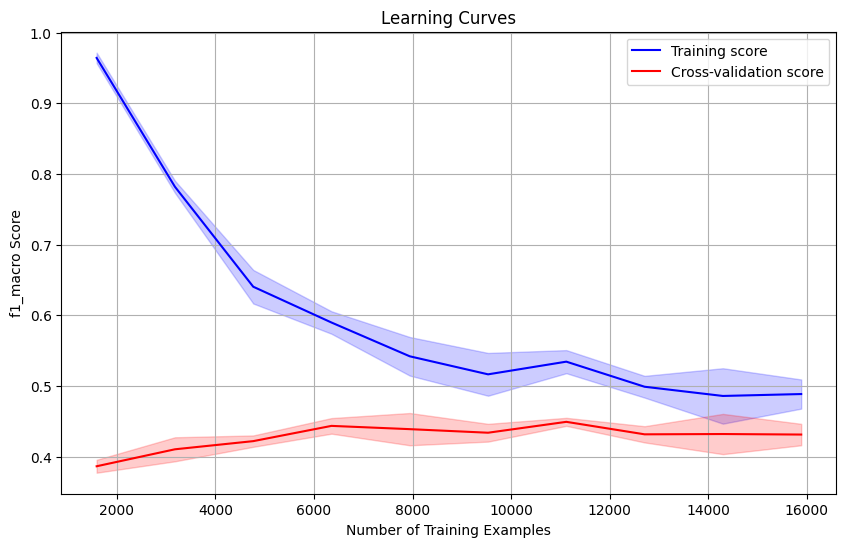

In [16]:
plot_learning_curve(best_model, X_train_transformed, y_train_val, 'f1_macro')

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.p

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.p

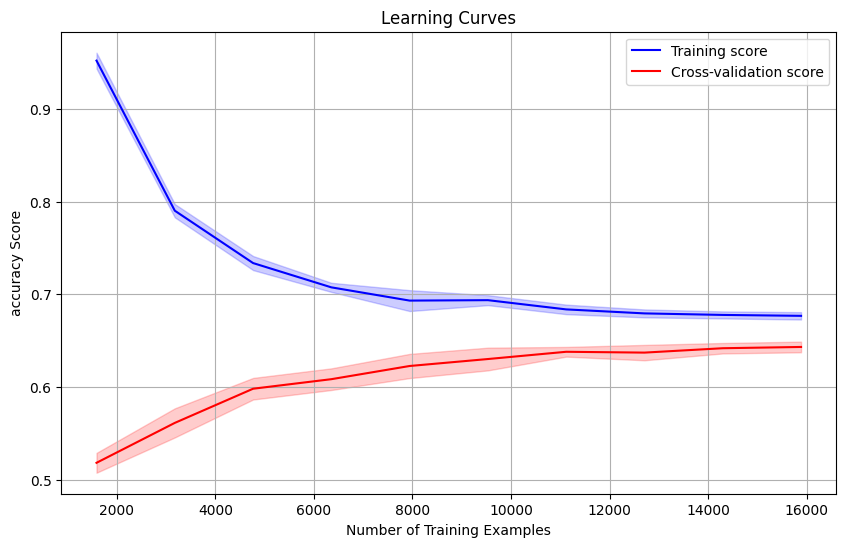

In [17]:
plot_learning_curve(best_model, X_train_transformed, y_train_val, 'accuracy')

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


test classification report
              precision    recall  f1-score   support

           0       0.56      0.67      0.61      1195
           1       0.39      0.05      0.08       333
           2       0.73      0.83      0.78      1609
           3       0.44      0.12      0.19       228

    accuracy                           0.65      3365
   macro avg       0.53      0.42      0.41      3365
weighted avg       0.62      0.65      0.61      3365



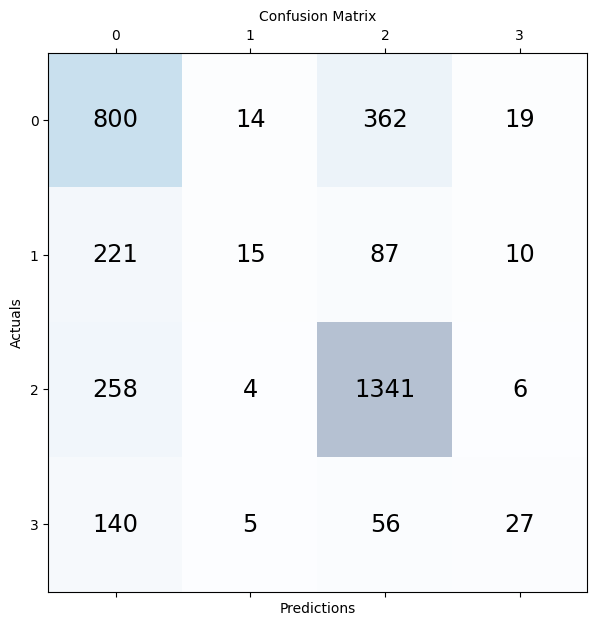

In [18]:
# test set evaluation
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_transformed, y_train_val)
# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

Overfitting solutions:  
* regularization - L1 or L2 regularization to the linear models (e.g., LinearSVC) or the tree-based model (e.g., XGBoost)  
* data augmentation - creating variations of existing sentences through techniques like paraphrasing or back-translation  
* cross-validation 
* hyperparameter tuning
* pre-trained models like transformers 
* use techniques like class weighting or resampling to address class imbalance  
* explore other models that are less prone to overfitting or require fewer features

It does not make sense to do feature selection, because in this current approach we take the mean of the embeddings for each text, so traditional feature selection techniques like removing certain words or features might not be applicable. However, we can still perform feature engineering by exploring other text-specific features that could be relevant for the classification task. For example, sentence length, part-of-speech tags, or other linguistic features.

<span style="color:white; font-size:18px;background-color:red">* Training LinearSVC with Class Weighting</span>  
https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html  

In the context of LinearSVC in scikit-learn, the class_weight parameter allows you to control the penalty applied to different classes during model training. It adjusts the parameter C of the Support Vector Classification (SVC) for each class, which influences the trade-off between maximizing the margin and minimizing the classification error for that class.

'balanced': When you set class_weight='balanced', the model automatically adjusts the weights inversely proportional to the class frequencies in the input data. In other words, it will assign higher weights to the minority classes and lower weights to the majority classes. 

class weights: Some algorithms allow you to assign different weights to classes during training. By giving higher weights to the minority classes, you can make the model focus more on learning from these classes.

In [20]:
# combine in the same string
feature_set=['narrative_embeddings', 'embeddings_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# mean of the sentence embeddings
X_train_transformed, X_test_transformed= embeddings_transformation(X_train_val_combined,X_test_combined,w2v)

# Create the stratified 6-fold cross-validation splitter for validation data
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

# or perform RandomizedSearchCV with cross-validation on the validation set
classifier= LinearSVC(class_weight='balanced')
random_search = RandomizedSearchCV(classifier, param_distributions=param_grids, n_iter=40, scoring='f1_macro', cv=cv, random_state=42)

# Capture warnings during grid search
with warnings.catch_warnings(record=True) as caught_warnings:
    # Run grid search
    random_search.fit(X_train_transformed, y_train_val)

# Check captured warnings and print corresponding hyperparameter combinations
for warning in caught_warnings:
    if 'ConvergenceWarning' in str(warning.message):
        print(f"Warning: {warning.message}")
        print("Parameters:", warning.category.parameters)

# Get the best model with tuned hyperparameters
best_model = random_search.best_estimator_
print("best mean cross-validation f1-score: {:.3f}".format(random_search.best_score_))
print("Best Hyperparameters:", random_search.best_params_)

best mean cross-validation f1-score: 0.499
Best Hyperparameters: {'penalty': 'l1', 'max_iter': 9000, 'loss': 'squared_hinge', 'dual': False, 'C': 1.0}


In [21]:
# Perform cross-validation with StratifiedKFold
f1_scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring='f1_macro')
acc_scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring='accuracy')
rec_scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring='recall_macro')
prec_scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring='precision_macro')
print("Individual fold F1-scores:", f1_scores)
print("Mean cross-validation F1-score:", f1_scores.mean())
print("Individual Precision:", prec_scores)
print("Mean cross-validation Precision:", prec_scores.mean())
print("Individual Accuracy:", acc_scores)
print("Mean cross-validation Accuracy:", acc_scores.mean())
print("Individual Recall:", rec_scores)
print("Mean cross-validation Recall:", rec_scores.mean())

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.p

Individual fold F1-scores: [0.49058056 0.50709436 0.50347172 0.48328834 0.51403311 0.49106637]
Mean cross-validation F1-score: 0.49825574429079683
Individual Precision: [0.48506898 0.50125849 0.49708936 0.47630794 0.50753766 0.48776454]
Mean cross-validation Precision: 0.49250449342788055
Individual Accuracy: [0.62303335 0.63058527 0.62932662 0.61347183 0.64400378 0.62574756]
Mean cross-validation Accuracy: 0.6276947358488834
Individual Recall: [0.51470615 0.52515466 0.52272351 0.50069408 0.52836256 0.51437416]
Mean cross-validation Recall: 0.5176691858831493


d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.p

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.p

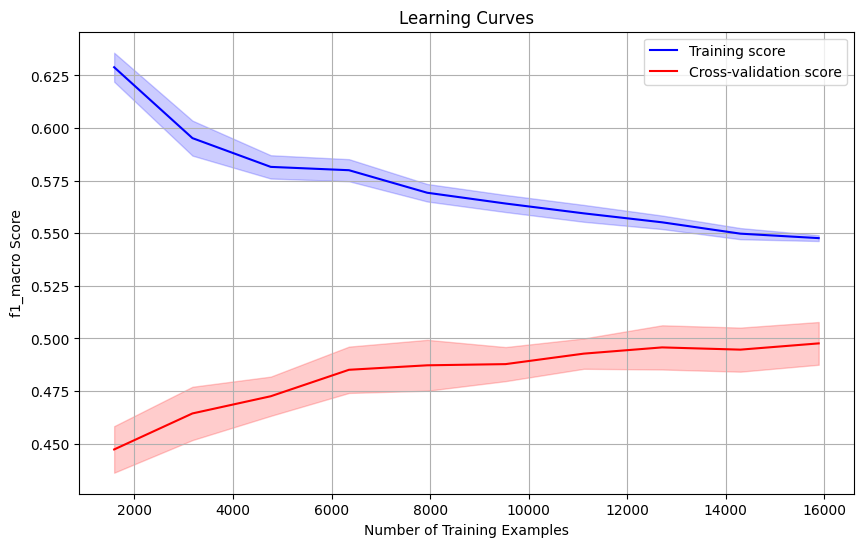

In [22]:
plot_learning_curve(best_model, X_train_transformed, y_train_val, 'f1_macro')

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.p

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.p

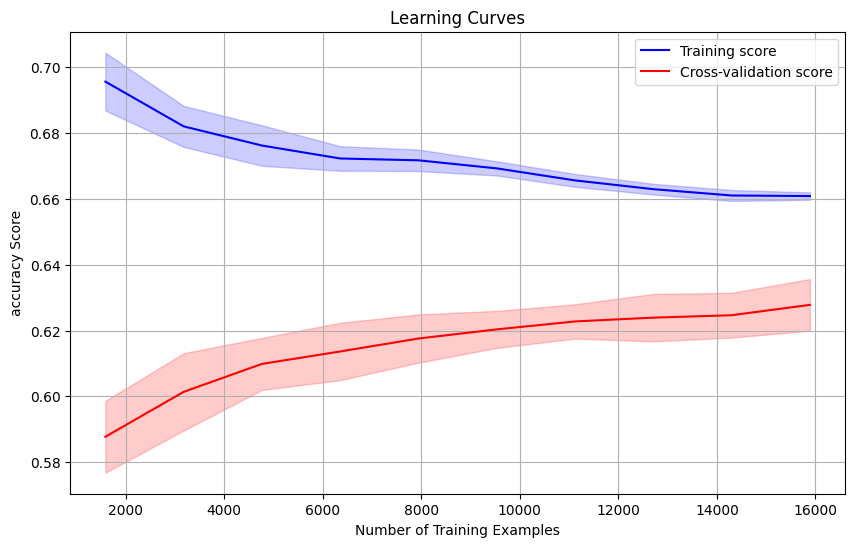

In [23]:
plot_learning_curve(best_model, X_train_transformed, y_train_val, 'accuracy')

d:\ms data science\nlp tese\envs\env1\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


test classification report
              precision    recall  f1-score   support

           0       0.61      0.54      0.57      1195
           1       0.29      0.22      0.25       333
           2       0.76      0.80      0.78      1609
           3       0.32      0.47      0.38       228

    accuracy                           0.63      3365
   macro avg       0.49      0.51      0.50      3365
weighted avg       0.63      0.63      0.63      3365



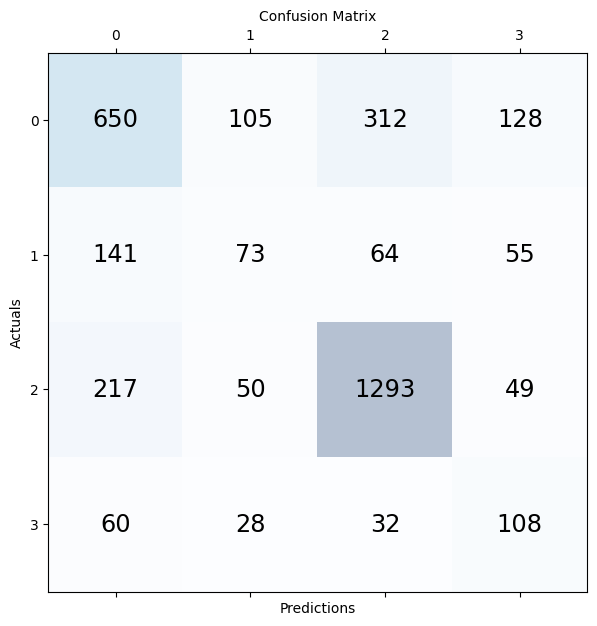

In [24]:
# test set evaluation
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_transformed, y_train_val)
# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

## **2. Gradient Boosting**    
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html    

https://datagy.io/python-optuna/  

https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.HyperbandPruner.html

<span style="color:white; font-size:18px;background-color:red">* doing nothing to fix class imbalance</span>

In [12]:
def objective(trial):
    feature_set=['narrative_embeddings', 'embeddings_title']
    X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
    X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

    # mean of the sentence embeddings
    X_train_transformed, X_test_transformed= embeddings_transformation(X_train_val_combined,X_test_combined,w2v)
    
    # Define the hyperparameter search space
    params = {
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
      'n_estimators': trial.suggest_int('n_estimators', 50, 500),
      'max_depth': trial.suggest_int('max_depth', 3, 15),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
      'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
      'random_state': 42  # Add other hyperparameters as needed
    }

    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train_transformed, y_train_val)

    # Evaluate the classifier on the validation set
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X_train_transformed, y_train_val, cv=cv, scoring='f1_macro')

    return f1_scores.mean()

In [13]:
import os
path = 'D:\\MS DATA SCIENCE\\NLP TESE\\optuna'
database_filename = 'description_title_word2vec.db'

# Full path to the SQLite database file in Google Drive
database_path = os.path.join(path, database_filename)

# Set the SQLite database path to Google Drive path
storage = optuna.storages.RDBStorage(url=f'sqlite:///{database_path}')

In [ ]:
study = optuna.create_study(storage=storage, direction='maximize', study_name='description_title_word2vec',load_if_exists=True)
study.optimize(objective, n_trials=30, n_jobs=-1)

trial = study.best_trial
print('Val Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-08-23 00:47:12,634] A new study created in RDB with name: description_title_word2vec
[I 2023-08-23 00:59:15,257] Trial 0 finished with value: 0.341428867795059 and parameters: {'learning_rate': 0.019408302118958935, 'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 66, 'subsample': 0.5059465050176863}. Best is trial 0 with value: 0.341428867795059.
[I 2023-08-23 01:02:54,591] Trial 1 finished with value: 0.3824155790858665 and parameters: {'learning_rate': 0.10591701314618568, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 81, 'subsample': 0.5609195203913896}. Best is trial 1 with value: 0.3824155790858665.


In [ ]:
# Plot the optimization history
import optuna.visualization as vis
study = optuna.load_study(study_name='description_title_word2vec', storage=storage)
vis.plot_optimization_history(study)

In [ ]:
# in case it fails
# Load the existing study by providing the study name and storage URL
study = optuna.load_study(study_name='description_title_word2vec', storage=storage)

# Continue optimization with additional trials
study.optimize(objective, n_trials=20)  

In [ ]:
trial = study.best_trial
print('Val Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
feature_set=['narrative_embeddings', 'embeddings_title']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# mean of the sentence embeddings
X_train_transformed, X_test_transformed= embeddings_transformation(X_train_val_combined,X_test_combined,w2v)

best_model = XGBClassifier(
    colsample_bytree=0.6660707896339382,
    eta=0.1865203620258158,
    gamma=0.4869470425232074,
    max_depth=5,
    min_child_weight=8,
    n_estimators=747,
    reg_alpha=0.2615683528029101,
    reg_lambda=0.20706126430246635,
    subsample=0.87307714888806
)
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
f1_scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring='f1_macro')
acc_scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring='accuracy')
rec_scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring='recall_macro')
prec_scores = cross_val_score(best_model, X_train_transformed, y_train_val, cv=cv, scoring='precision_macro')

print("Individual fold F1-scores:", f1_scores)
print("Mean cross-validation F1-score:", f1_scores.mean())
print("Individual Precision:", prec_scores)
print("Mean cross-validation Precision:", prec_scores.mean())
print("Individual Accuracy:", acc_scores)
# or np.mean
print("Mean cross-validation Accuracy:", acc_scores.mean())
print("Individual Recall:", rec_scores)
print("Mean cross-validation Recall:", rec_scores.mean())

In [ ]:
plot_learning_curve(best_model, X_train_transformed, y_train_val, 'f1_macro')

In [ ]:
plot_learning_curve(best_model, X_train_transformed, y_train_val, 'accuracy')

In [ ]:
# test set evaluation
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_transformed, y_train_val)
# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

<span style="color:white; font-size:18px;background-color:red">* using class weighting </span>

<span style="color:white; font-size:18px;background-color:red">* resampling </span>

<span style="color:white; font-size:18px;background-color:red">* Resampling with smote</span>

In [45]:
y_train_val.value_counts()

2    9119
0    6771
1    1886
3    1289
Name: reason, dtype: int64

In [46]:
y_train_balanced.value_counts()

2    9119
0    9119
3    9119
1    9119
Name: reason, dtype: int64

In [47]:
X_train_val_combined_transformed

<19065x256505 sparse matrix of type '<class 'numpy.float64'>'
	with 2558135 stored elements in Compressed Sparse Row format>

In [48]:
X_train_balanced

<36476x256505 sparse matrix of type '<class 'numpy.float64'>'
	with 7141927 stored elements in Compressed Sparse Row format>